In [73]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
import matplotlib 

from itertools import product

from astropy.io import fits
from astropy.table import Table, join

import sys
import os
import tqdm

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

import h5py
from dustapprox.models import PrecomputedModel

import emcee
import corner

In [74]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '../Data/230420_CAResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [75]:
### Dustmap coordinates
distance = np.linspace(0, 1000, 200)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 200)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

(200, 200, 200)


shape: (601, 601, 161)
(601, 601, 161)


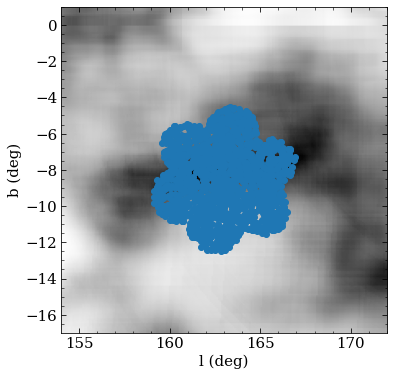

In [76]:
### Get Vergely+ (2022) dustmap for same points as Bayestar, now that it's in dustmaps
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

vergelyquery = Vergely2022Query(map_fname = 
                                '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')
vergely = vergelyquery(coords) * A0Coeff

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.scatter(CA_meta['GLON'], CA_meta['GLAT'])
plt.show()

In [77]:
lambda0 = 15272.42 
sigma0 = 1.15

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
window_inds = np.where(window)[0]
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [78]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [79]:
loff = 1
boff = 1
l_cen, b_cen, = (163 + loff , -8.4 + boff)
s= select_stars(CA_meta, l_cen, b_cen, radius = .4)

In [80]:
def find_nearest(ll, bb):
    l_sel = l_
    b_sel = b_

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(vergely[b_ind, l_ind, :]) #needs to be b then l then :

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(vergely[b_ind, l_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline)) 
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

def Differential_Amplitude(dAv_dd, dd):
     return  0.024 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd

def dAV_dd_array(l, b, bins, star_dist, dmap_dist = distance):
    l_ind, b_ind = find_nearest(l, b)
    verg_sightline = np.copy(vergely[b_ind, l_ind, :]) 
    dAVdd = np.zeros(len(bins)-1)
    for i in range(len(dAVdd)):
        bin_min, bin_max = bins[i], bins[i+1]
        if bin_min < star_dist:
            dist_max = bin_max
            if bin_max >= star_dist:
                dist_max = star_dist
        else:
            dist_max = -np.inf

            
        dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

    return dAVdd

In [81]:
class sightline:
    ### Container object for stars, sightline dAV_dd, velocity, and spaxel assignment.
    def __init__(self, stars, bins = None, **kwargs):
        self.stars = stars
        dist = self.stars['DIST']

        if bins is not None:
            h = np.histogram(dist, bins)[0]
            self.bins = np.insert(bins[1:][h != 0], 0, bins[0])
            self.bin_inds = np.digitize(dist, bins)
        else:
            self.make_bins()
            self.bin_inds = np.digitize(dist, self.bins)  
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs()
        self.init_signals = self.model_signals(self.rvelo, self.dAVdd)
        
    def make_bins(self, binsep = 10, dmin = 0):
        ### Assigns stars to distance bins if bins are not already supplied.
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), 0, dmin))

        i = 0
        while i >= 0:
            next_bin = np.min(bins[bins > bins[i]])
            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins
            
    def get_DIBs(self):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        # dAVdd = np.zeros(len(self.bins))

        for i in range(len(self.stars)):
            star = self.stars[i]
            res_hdul = fits.open(get_ca_res(star['FILE']))
            signals[i, :] = res_hdul[1].data[window]
            signal_errs[i, :] = res_hdul[2].data[window]
            l, b = star['GLON'], star['GLAT']
            dAVdd[i] = dAV_dd_array(l, b, self.bins, star['DIST'])
        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        # self.dAVdd = dAV_dd_array(np.median(self.stars['GLON']), np.median(self.stars['GLAT']), 
        #                           self.bins, np.max(self.bins))

    def model_signals(self, rvelo, dAVdd = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins) - 1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = Differential_Amplitude(dAVdd, self.bins[1:]-self.bins[:-1])

        # def single_signal(bin_index, amp = amp):
        #     amp[bin_index+1:] = 0
        #     voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
        #     summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        #     continuum = lambda x, m, b : m * (x - lambda0) + b
        #     cont = continuum(wavs_window, m, b)

        #     return summed_DIB  + cont 
        def single_signal(amp):
            amp[bin_index+1:] = 0
            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)

            return summed_DIB  + 1 
        print(self.dAVdd)
        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = self.dAVdd[i, :]
            amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp)
        return signals
            
    ### + A vector of dAV_dd prior (e.g. sigma) with sigma_dAV_dd(d > d_star) = 0 


    ### + A vector of velocities per distance bin

    ### Consider Gaussian fitting each feature first


[[0.01210089 0.20368241 0.00380195 0.00751804 0.01679003 0.02512482
  0.01056164 0.01227203 0.02381775 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.01188593 0.20350311 0.00380195 0.00194503 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.01188593 0.20969907 0.00380195 0.00430949 0.01679003 0.02512482
  0.00906532 0.01328535 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.01206281 0.21241855 0.00348508 0.00650869 0.01526277 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.01184785 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.01196631 0.21379714 0.00380195 0.00385346 0.01473631 0.02443868
  0.01147758 0.0137529  0.0233521  0.03191835 0.01993208 0.04027232
  0.01189209 

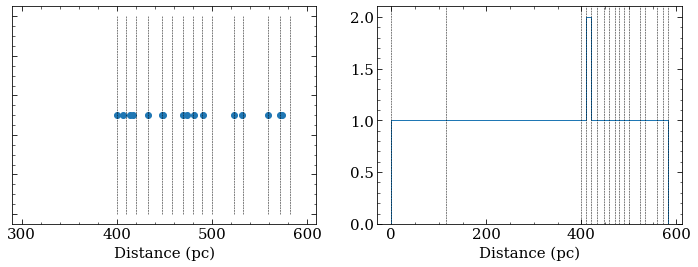

In [82]:
a = sightline(CA_meta[s])
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
ax = axs[0]
ax.plot([a.bins, a.bins], [np.zeros(len(a.bins)), np.ones(len(a.bins))], c='k', linestyle = 'dashed', linewidth = 0.5)
ax.scatter(CA_meta[s]["DIST"], np.ones(len(CA_meta[s])) * 0.5)
ax.set_xlabel('Distance (pc)')
ax.set_yticklabels('')
ax.set_xlim(290, 610)


axs[1].hist(a.stars['DIST'], a.bins, histtype = 'step')
ymin, ymax = axs[1].get_ylim()
axs[1].set_ylim(ymin, ymax)
axs[1].plot([a.bins, a.bins], [np.zeros(len(a.bins)), ymax * np.ones(len(a.bins))], c='k', linestyle = 'dashed', linewidth = 0.5)
axs[1].set_xlabel('Distance (pc)')
fig.set_facecolor('white')
plt.show()

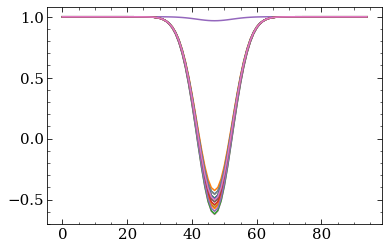

In [83]:
for i in range(len(a.init_signals)):
    plt.plot(a.init_signals[i, :])
plt.show()

In [84]:
signals = a.signals
signal_errs = a.signal_errs
voxel_dAv_dd = a.dAVdd
voxel_dist = a.bins[1:]
### The issue is that now I have multiple stars in each bin, so I'm going to need to figure that part out
### NEXT WEEK


print(len(signals), len(signal_errs), len(voxel_dAv_dd), len(voxel_dist))

def make_signals(rvelo, m = 0, b = 1, dAv_dd = voxel_dAv_dd, dist = voxel_dist, sigma0=sigma0, **kwargs):
    signals = np.zeros((len(dist), len(wavs_window)))
    amp = Differential_Amplitude(dAv_dd, dd = 5) # CONVERT THIS


    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(dist), 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))

    def single_signal(dist_max, i, amp = amp):
        # print(dist_max)
        amp = -np.copy(amp)
        amp[dist > dist_max] = 0
        voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        continuum = lambda x, m, b : m * (x - lambda0) + b
        cont = continuum(wavs_window, m, b)

        return summed_DIB  + cont
    

    for i in range(len(dist)):
        dist_max = dist[i]
        signals[i, :] = single_signal(dist_max, i)
    
    signals = signals #+ continuum(wavs_window, m, b)[np.newaxis, :]
    return signals


17 17 17 16


In [85]:
def loglikely_2(p, signal = signals, sigma = signal_errs, **kwargs):
    v = p[:int(len(p)/2)]
    av = p[int(len(p)/2):]
    return - 0.5 * np.sum((signal - make_signals(v, dAv_dd = av, sigma0 = sigma0, **kwargs))**2 / (sigma**2)) 

def logprior_v(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        return -np.inf
    return 0.0

def logprior_av(av, AV_base = voxel_dAv_dd, AV_max = 1):   
    if (np.any(np.abs(av - AV_base) > AV_max)):
        return -np.inf
    if ((np.any(av < 0))):
        return -np.inf
    return 0.0

def logprob_2(p, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    # print('......')
    # print(p.shape)
    # print(p)
    # print('......')
    v = p[ :int(len(p)/2)]
    av = p[int(len(p)/2):]
    # sig = p[-1]
    lp = logprior(v, **kwargs)
    lp_av = logprior_av(av)

    if (not np.isfinite(lp)) | (not np.isfinite(lp_av)):
        return -np.inf
    return lp + lp_av + loglikely(p, **kwargs)

In [86]:
ndim = len(a.dAVdd) 
ndim_amp = int(2 * ndim)
def MCMC(steps = 1000, nwalkers = 100):

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs})
    init = 5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init[:, ndim:] = np.abs(a.dAVdd[np.newaxis, :] + 0.5*(np.random.random(init[:, ndim:].shape)-0.5))
    print(init.shape)
    sampler.run_mcmc(init,  steps);
    
    return sampler

In [87]:
MCMC()

ValueError: operands could not be broadcast together with shapes (1,17,16) (100,17) 